# Example of fitting with a GP: K2-229

In this notebook, we will fit the two-planet system K2-229 both without and with a Gaussian Process (GP), to demonstrate how GPs can be essential for modelling correlated noise from stellar activity.

In [ ]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import ravest.prior
from ravest.fit import Fitter
from ravest.model import calculate_mpsini
from ravest.param import Parameter, Parameterisation

The data for K2-229 was used in [Osborne et al 2025 A&A, 693, A4 (2025)](https://doi.org/10.1051/0004-6361/202452127) and downloaded from [VizieR J/A+A/693/A4](https://doi.org/10.26093/cds/vizier.36930004).

In [ ]:
fpath = Path.cwd() / "example_data" / "K2-229.csv"
data = pd.read_csv(fpath)
data

BJD            RV      e_RV      FWHM       BIS  System  \
0    2.457798e+06  22965.967262  1.580978  0.002236  0.002236  K2-229   
1    2.457798e+06  22971.043308  1.471306  0.002081  0.002081  K2-229   
2    2.457797e+06  22963.492334  1.562922  0.002210  0.002210  K2-229   
3    2.457797e+06  22967.865369  1.499985  0.002121  0.002121  K2-229   
4    2.457796e+06  22970.042232  1.363895  0.001929  0.001929  K2-229   
..            ...           ...       ...       ...       ...     ...   
115  2.457803e+06  22992.061104  1.902412  0.002690  0.002690  K2-229   
116  2.457803e+06  22986.700197  1.512577  0.002139  0.002139  K2-229   
117  2.457803e+06  22988.074353  1.580983  0.002236  0.002236  K2-229   
118  2.457802e+06  22988.311991  1.448587  0.002049  0.002049  K2-229   
119  2.457802e+06  22982.833389  1.475159  0.002086  0.002086  K2-229   

          TIC              GaiaDR2  
0    98720809  3583630929786305280  
1    98720809  3583630929786305280  
2    98720809  3583630929786305280  
3    98720809  3583630929786305280  
4    98720809  3583630929786305280  
..        ...                  ...  
115  98720809  3583630929786305280  
116  98720809  3583630929786305280  
117  98720809  3583630929786305280  
118  98720809  3583630929786305280  
119  98720809  3583630929786305280  

[120 rows x 8 columns]

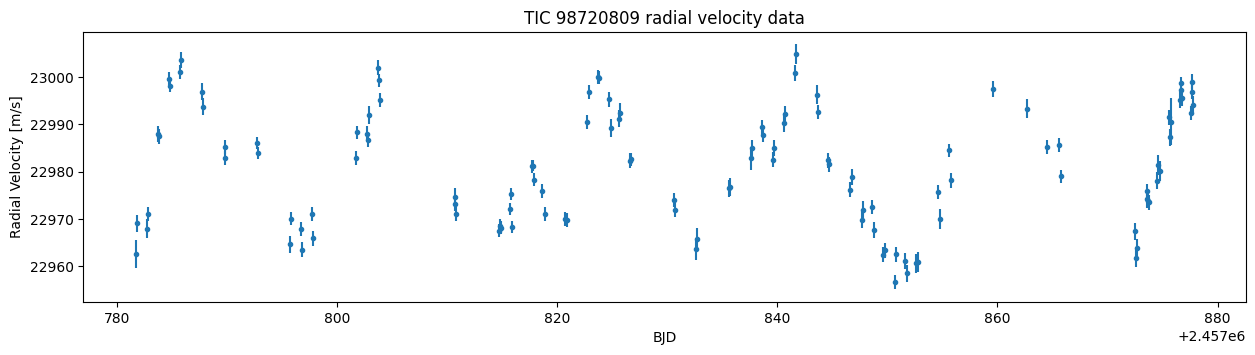

In [ ]:
plt.figure(figsize=(15,3.5))
plt.title("TIC 98720809 radial velocity data")
plt.ylabel("Radial Velocity [m/s]")
plt.xlabel("BJD")
plt.errorbar(data["BJD"], data["RV"], yerr=data["e_RV"], marker=".", linestyle="None")
plt.show()

---

# Fitting without GP (white-noise model)

For more details on fitting a white noise model, see the [fitting tutorial](https://ravest.readthedocs.io/en/latest/Examples/example_fitting.html) notebook.

Note that we truncate the BJD times to BTJD (Barycentric TESS Julian Date) by subtracting 2457000 (this is done mostly to make plot labels and $T_c$ values more readable!)

In [ ]:
parameterisation=Parameterisation("P K e w Tc")
fitter = Fitter(planet_letters=["b","c"], parameterisation=parameterisation)
fitter.add_data(
                time=(data["BJD"].to_numpy()-2457000), 
                vel=data["RV"].to_numpy(),
                verr=data["e_RV"].to_numpy(),
                t0=np.mean(data["BJD"].to_numpy()-2457000),
)
fitter

Construct the parameters dict. The values for $P$ and $T_c$ are the reported values from Supplementary Table 6 of [Santerne et al. 2018](https://doi.org/10.1038/s41550-018-0420-5). For the sake of making this notebook run quickly, we use their reported values as starting points.

In [ ]:
# Construct the params dict
params = {
          "P_b": Parameter(0.584249, "d", fixed=False),
          "K_b": Parameter(10, "m/s", fixed=False),
          "e_b": Parameter(0, "", fixed=True),
          "w_b": Parameter(np.pi/2, "", fixed=True),
          "Tc_b": Parameter(2457586.9750-2457000, "d", fixed=False),

          "P_c": Parameter(8.32835, "d", fixed=False),
          "K_c": Parameter(10, "m/s", fixed=False),
          "e_c": Parameter(0, "", fixed=True),
          "w_c": Parameter(np.pi/2, "", fixed=True),
          "Tc_c": Parameter(2457536.3647-2457000, "d", fixed=False),

          "g": Parameter(np.mean(data["RV"].to_numpy()), "m/s", fixed=False),
          "gd": Parameter(0, "m/s/day", fixed=True),
          "gdd": Parameter(0, "m/s/day^2", fixed=True),
          
          "jit": Parameter(0.01, "m/s", fixed=False),
        }

fitter.params = params
fitter.params

{'P_b': Parameter(value=0.584249, unit='d', fixed=False),
 'K_b': Parameter(value=10, unit='m/s', fixed=False),
 'e_b': Parameter(value=0, unit='', fixed=True),
 'w_b': Parameter(value=1.5707963267948966, unit='', fixed=True),
 'Tc_b': Parameter(value=586.9750000000931, unit='d', fixed=False),
 'P_c': Parameter(value=8.32835, unit='d', fixed=False),
 'K_c': Parameter(value=10, unit='m/s', fixed=False),
 'e_c': Parameter(value=0, unit='', fixed=True),
 'w_c': Parameter(value=1.5707963267948966, unit='', fixed=True),
 'Tc_c': Parameter(value=536.3646999998018, unit='d', fixed=False),
 'g': Parameter(value=22981.045158814868, unit='m/s', fixed=False),
 'gd': Parameter(value=0, unit='m/s/day', fixed=True),
 'gdd': Parameter(value=0, unit='m/s/day^2', fixed=True),
 'jit': Parameter(value=0.01, unit='m/s', fixed=False)}

Define the prior functions for the free parameters. You can see a list of available prior functions at `ravest.prior.PRIOR_FUNCTIONS`.

In [ ]:
ravest.prior.PRIOR_FUNCTIONS

['Uniform',
 'EccentricityUniform',
 'Normal',
 'TruncatedNormal',
 'HalfNormal',
 'Rayleigh',
 'VanEylen19Mixture',
 'Beta']

These are again based on the values used in [Santerne et al. 2018](https://doi.org/10.1038/s41550-018-0420-5). 

In [ ]:
rv_range = np.max(data["RV"]) - np.min(data["RV"])

# Construct the priors dict. Every parameter that isn't fixed requires a prior.
priors = {
          "P_b": ravest.prior.Normal(0.584250, 0.000015),
          "K_b": ravest.prior.Uniform(0,100),
          "Tc_b": ravest.prior.Normal(586.9746, 0.001),

          "P_c": ravest.prior.Normal(8.3274, 0.01),
          "K_c": ravest.prior.Uniform(0,100),
          "Tc_c": ravest.prior.Normal(536.3766, 0.001),

          "g": ravest.prior.Uniform(params["g"].value-rv_range, params["g"].value+rv_range),

          "jit": ravest.prior.Uniform(0, 100),
         }

fitter.priors = priors
fitter.priors

{'P_b': Normal(mean=0.58425, std=1.5e-05),
 'K_b': Uniform(lower=0, upper=100),
 'Tc_b': Normal(mean=586.9746, std=0.001),
 'P_c': Normal(mean=8.3274, std=0.01),
 'K_c': Uniform(lower=0, upper=100),
 'Tc_c': Normal(mean=536.3766, std=0.001),
 'g': Uniform(lower=22932.870701387474, upper=23029.219616242262),
 'jit': Uniform(lower=0, upper=100)}

In [ ]:
map_results = fitter.find_map_estimate(method="Powell")
map_results

MAP parameter results: {'P_b': 0.5842500280693602, 'K_b': 1.1866800881908564, 'Tc_b': 586.9746000576193, 'P_c': 8.340952412834435, 'K_c': 4.402464797446347, 'Tc_c': 536.3766040234827, 'g': 22980.85346966813, 'jit': 11.75080179073743}


 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 460.67140313317424
       x: [ 5.843e-01  1.187e+00  5.870e+02  8.341e+00  4.402e+00
            5.364e+02  2.298e+04  1.175e+01]
     nit: 3
   direc: [[ 1.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]
           [ 0.000e+00  1.000e+00 ...  0.000e+00  0.000e+00]
           ...
           [ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]
           [ 4.293e-07  1.562e-02 ... -2.540e-02  6.455e-03]]
    nfev: 231

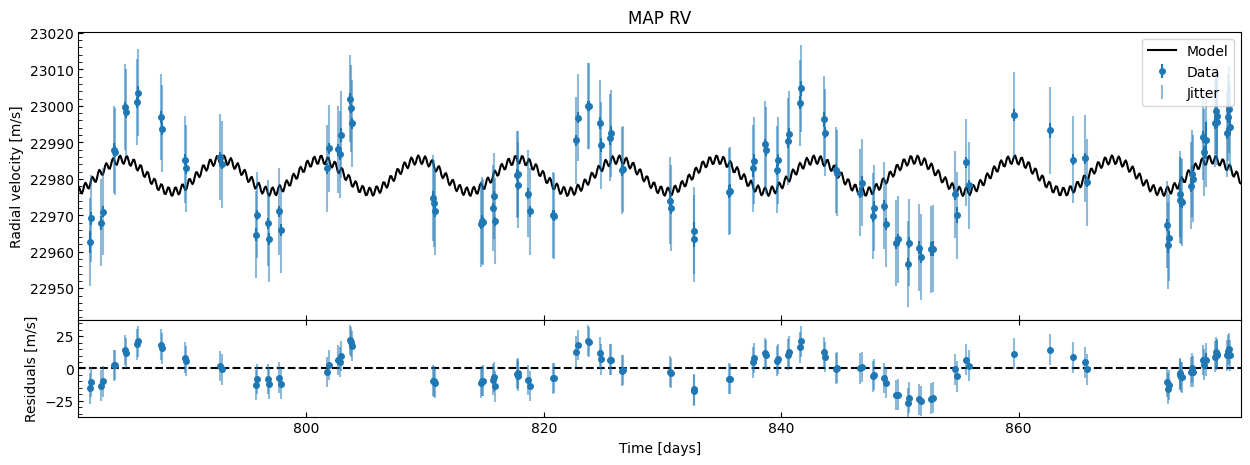

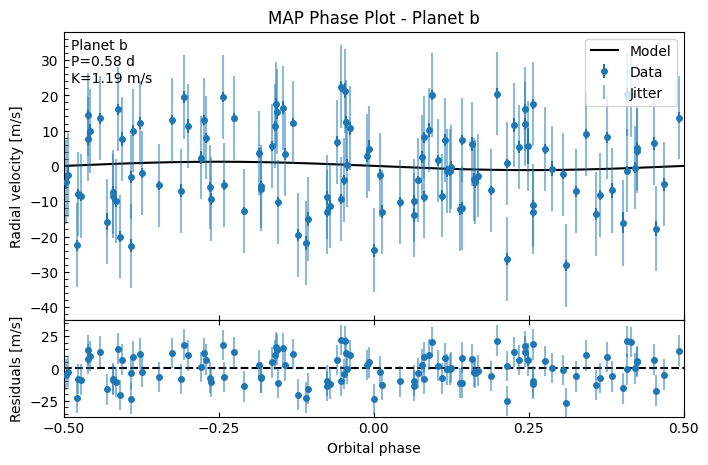

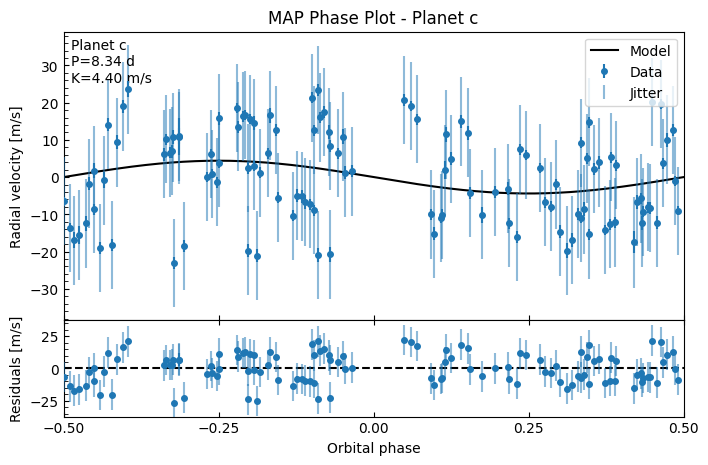

In [ ]:
fitter.plot_MAP_rv(map_result=map_results)
fitter.plot_MAP_phase(planet_letter="b", map_result=map_results)
fitter.plot_MAP_phase(planet_letter="c", map_result=map_results)

This is a terrible fit! We have contraints on $P$ and $T_c$ for both planets from the priors, but even then we can see the system RV still has a correlated pattern in the residuals. This is normally a sign there's either another potential planet, or there's strong periodic stellar activity that you'll want to use a GP to mitigate. Furthermore, on the phase plots, the residual spread is larger than the semi-amplitude of the planet! If we didn't a priori know there were planets here from transit photometry, then this wouldn't be a planetary detection at all.

Let's proceed with MCMC. To speed things up for this notebook, we'll use the minimum number of walkers (twice the number of free parameters) and we'll initialise the walkers in a small ball around the MAP values. You'll definitely want to use more than this (at least one hundred). You could also try initialising the walkers randomly within the full parameter- and prior-space with `fitter.generate_initial_walker_positions_random()`.

In [ ]:
nwalkers = 2 * fitter.ndim
mcmc_init = fitter.generate_initial_walker_positions_around_point(centre=map_results.x, nwalkers=nwalkers, verbose=False)

We'll enable convergence checking: at given intervals through the MCMC, it checks if two criteria are met: first, that the chains are more than 50 times longer than the estimated autocorrelation time for that parameter. Secondly, it checks that the estimate for autocorrelation time is stable (that it hasn't deviated by more than 1%). This is because the estimate becomes more accurate as you run for longer, so if you don't check for this you could accidentally stop the MCMC early.

In [ ]:
max_steps = 30_000
fitter.run_mcmc(initial_positions=mcmc_init, nwalkers=nwalkers, max_steps=max_steps, progress=True,
                multiprocessing=True,
                check_convergence=True, convergence_check_interval=1000, convergence_check_start=15000
                )  # This will take a few minutes!

INFO:root:Starting MCMC with convergence checks. (Maximum 30000 steps, checking convergence every 1000 steps after iteration 15000)...
 50%|████▉     | 14978/30000 [00:27<00:28, 521.12it/s]INFO:root:Convergence check: Step 15000: mean(tau)=101.5, max(tau)=129.3
INFO:root:Not yet converged (N/50>tau check: True, tau stability check: False)
 53%|█████▎    | 15967/30000 [00:29<00:25, 553.02it/s]INFO:root:Convergence check: Step 16000: mean(tau)=102.4, max(tau)=126.6
INFO:root:Not yet converged (N/50>tau check: True, tau stability check: False)
 57%|█████▋    | 16956/30000 [00:31<00:23, 557.69it/s]INFO:root:Convergence check: Step 17000: mean(tau)=104.3, max(tau)=129.6
INFO:root:Not yet converged (N/50>tau check: True, tau stability check: False)
 60%|█████▉    | 17958/30000 [00:32<00:19, 606.77it/s]INFO:root:Convergence check: Step 18000: mean(tau)=104.2, max(tau)=129.7
INFO:root:Not yet converged (N/50>tau check: True, tau stability check: False)
 63%|██████▎   | 18995/30000 [00:34<00:19

Let's take the last 10,000 samples and thin by 10, so that we have 1,000 effective samples per walker.

In [ ]:
nburn = fitter.sampler.iteration - 10_000
thin_rate = 10

# Get the samples as a numpy array
samples = fitter.get_samples_np(discard_start=nburn, discard_end=0, thin=thin_rate, flat=False) # shape (nsteps, nwalkers, ndim)

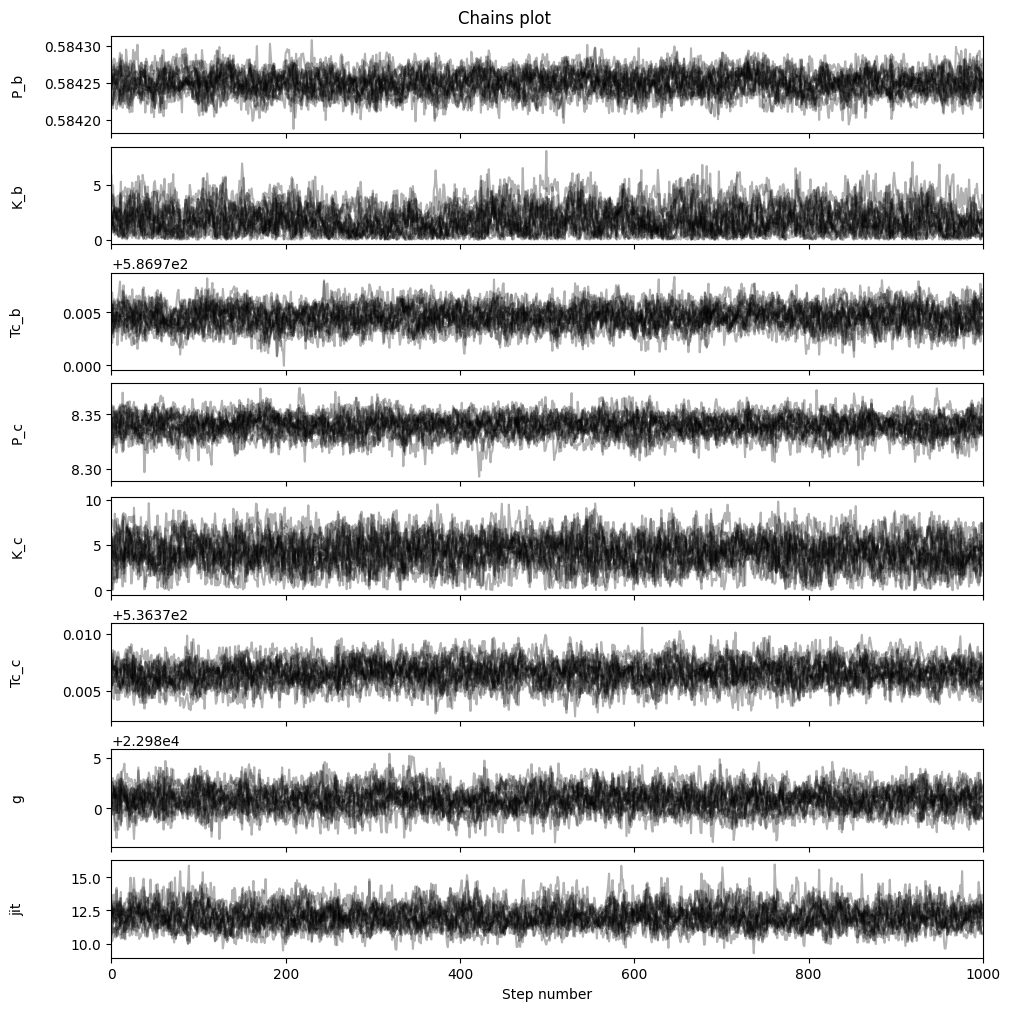

In [ ]:
fitter.plot_chains(discard_start=nburn, discard_end=0, thin=thin_rate, save=False)

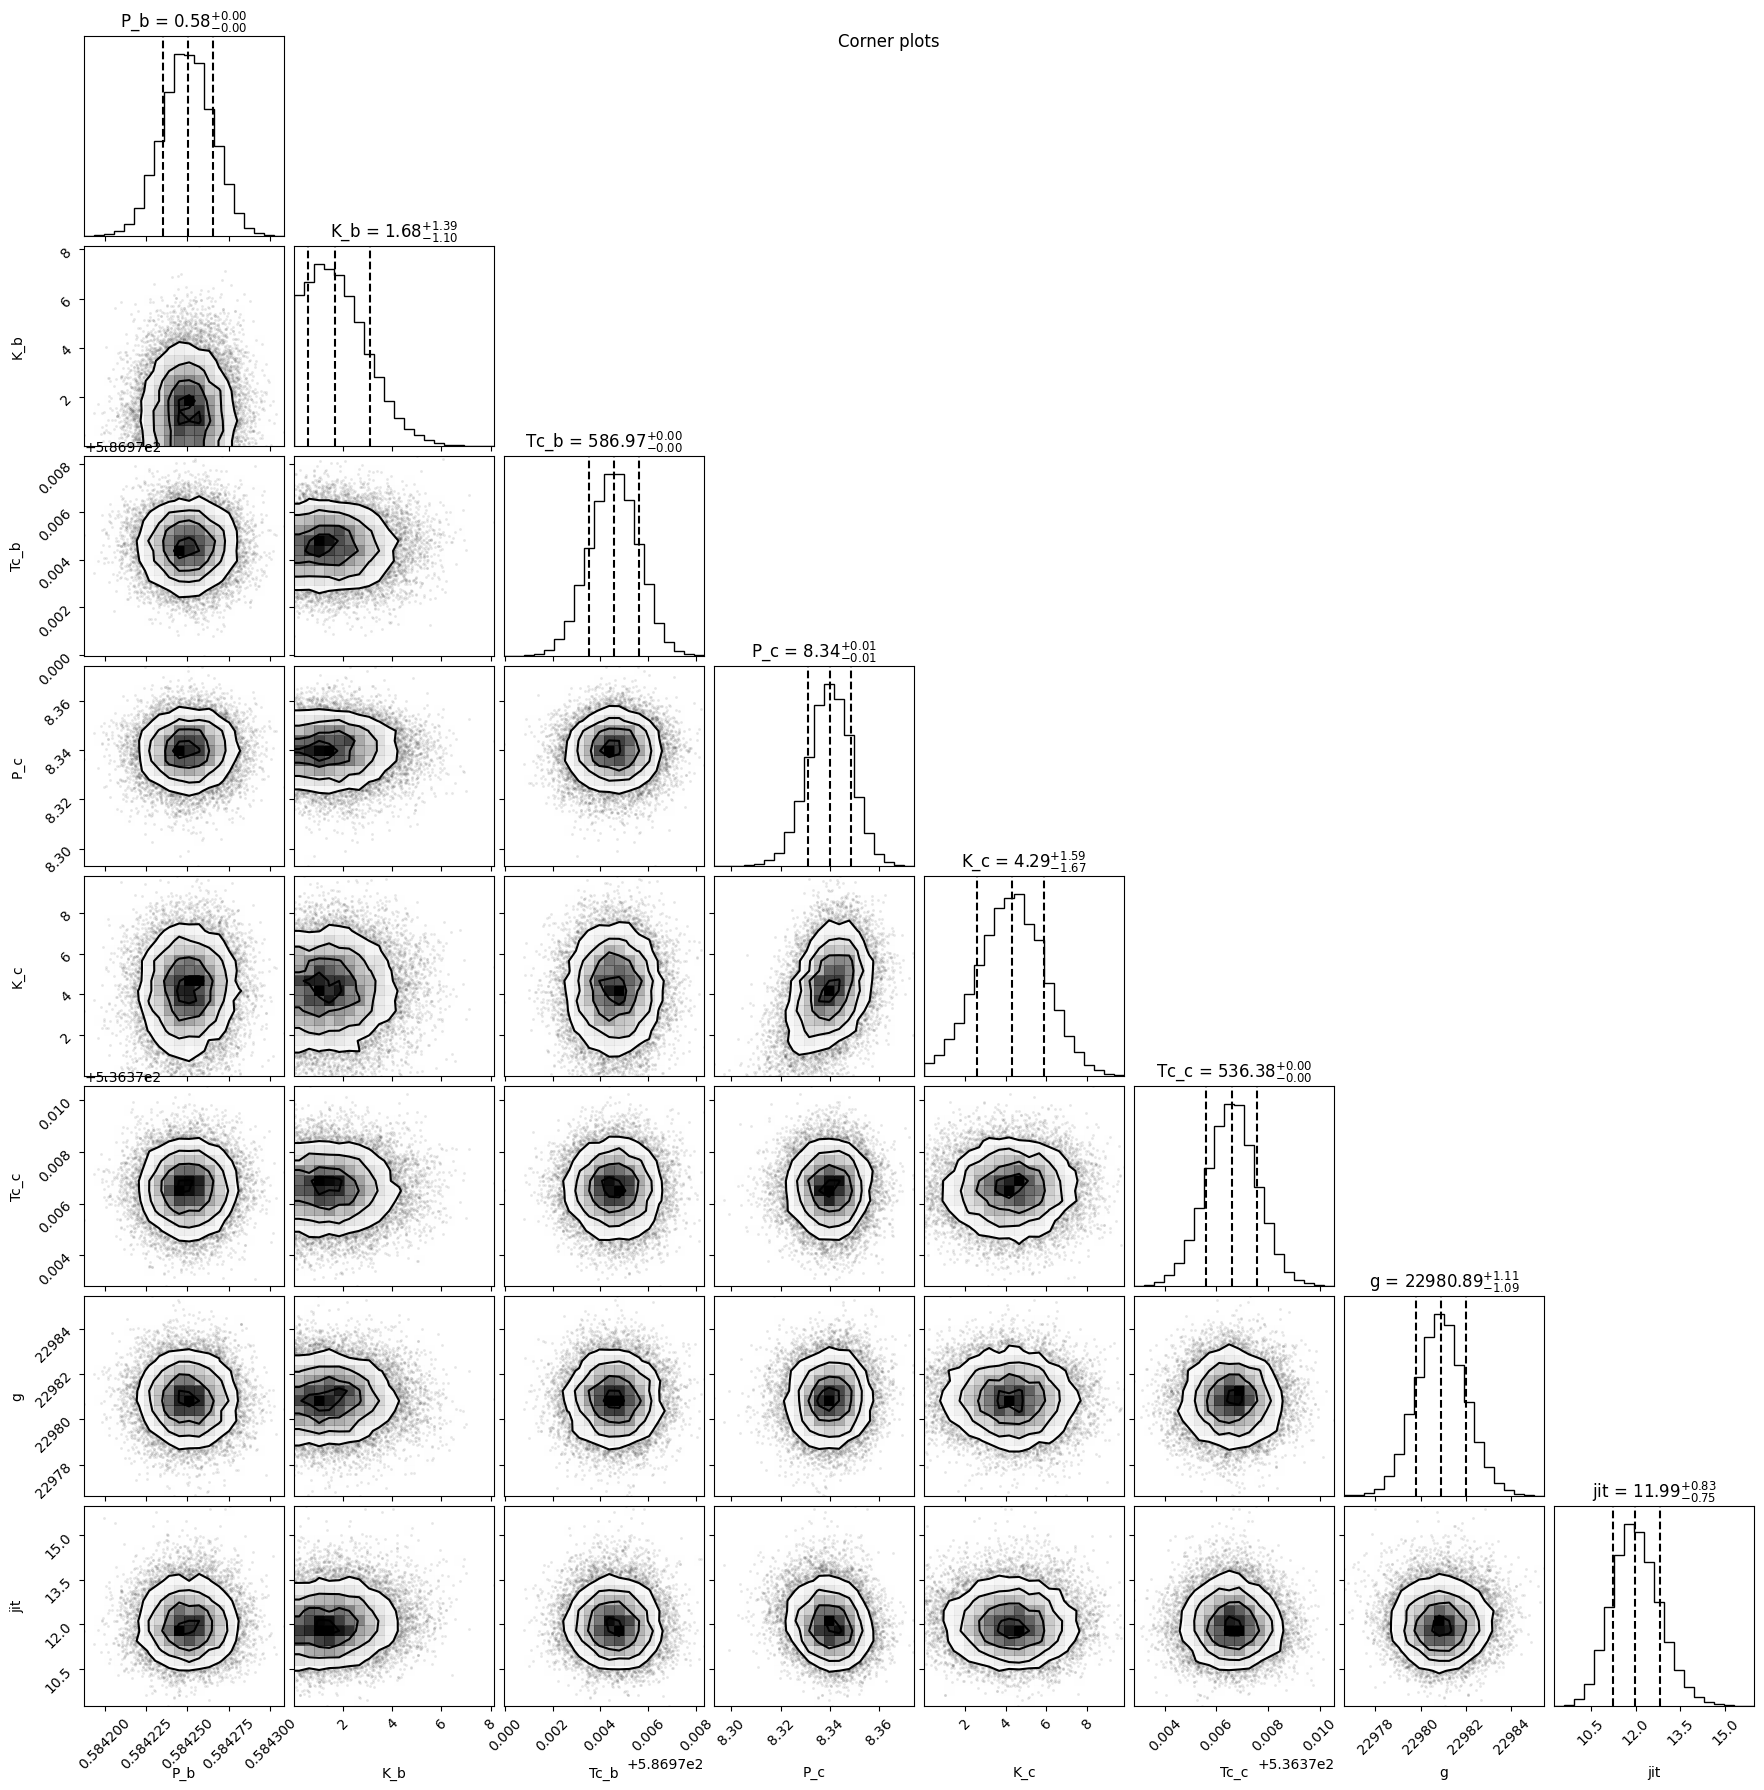

In [ ]:
fitter.plot_corner(discard_start=nburn, discard_end=0, thin=thin_rate, plot_datapoints=True, save=False)

The parameter distributions shown in the chains and corner plots look well-behaved (converged, more-or-less Normal distributions), but this is misleading - recall that the actual fit to the data (after the MAP optimisation) was poor. We can plot the posterior RV and Phase plots using our MCMC samples to check this:

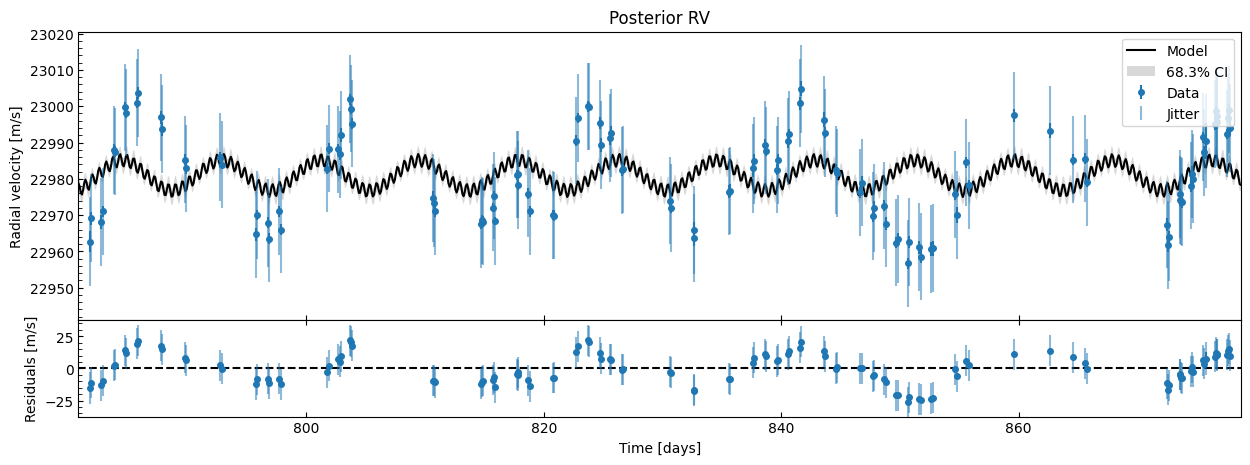

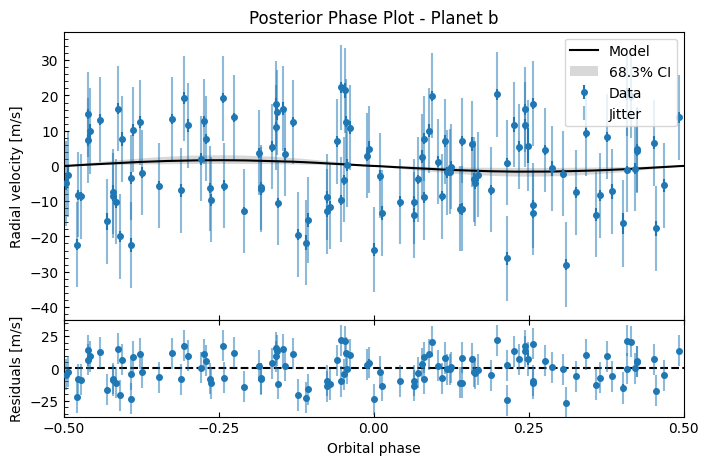

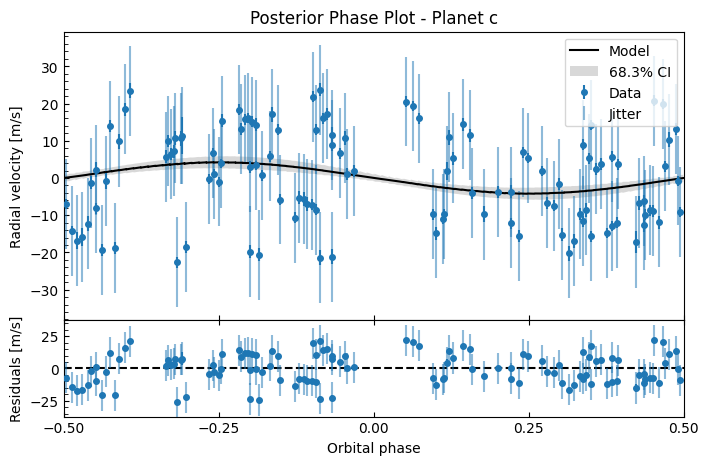

In [ ]:
# Use more aggressive thinning for RV/phase plots as they're computationally expensive
plot_thin = thin_rate * 10

fitter.plot_posterior_rv(discard_start=nburn, discard_end=0, thin=plot_thin)
fitter.plot_posterior_phase("b", discard_start=nburn, discard_end=0, thin=plot_thin)
fitter.plot_posterior_phase("c", discard_start=nburn, discard_end=0, thin=plot_thin)

Again, it's a terrible fit! This confirms that it wasn't just that the MAP failed to reach a good solution (which can happen), it shows that even across the posterior MCMC samples, the fit is consistently terrible, suggesting this white-noise model isn't suitable here. The correlated residuals indicate we should use a GP to model stellar activity.

We can quickly look at the final parameter values for each parameter's marginalised posterior distribution (say, the 50th percentile/median of each parameter's flattened chains) and compute some quick summary statistics of our fit so we can compare it with the GP fit later.

In [ ]:
# For the non-GP Fitter
print("Results for Fitter (white noise model)")

# Get flattened samples (with the same discard and thinning)
fitter_samples = fitter.get_samples_np(discard_start=nburn, discard_end=0, thin=10, flat=True)

# Calculate 50th percentile for each free parameter
fitter_medians = np.percentile(fitter_samples, 50, axis=0)
print(f"\nMedian free parameter values:")
for name, value in zip(fitter.free_params_names, fitter_medians):
    print(f"  {name}: {value}")

Results for Fitter (white noise model)

Median free parameter values:
  P_b: 0.5842501107455443
  K_b: 1.676778980518891
  Tc_b: 586.9745723509043
  P_c: 8.340066740525433
  K_c: 4.292408664544484
  Tc_c: 536.3765965189068
  g: 22980.893200505176
  jit: 11.989720311865938


In [ ]:
# Build complete params dict (combines free params with fixed params)
fitter_complete_dict = fitter.build_params_dict(fitter_medians)
fitter_complete_dict

{'e_b': 0,
 'w_b': 1.5707963267948966,
 'e_c': 0,
 'w_c': 1.5707963267948966,
 'gd': 0,
 'gdd': 0,
 'P_b': 0.5842501107455443,
 'K_b': 1.676778980518891,
 'Tc_b': 586.9745723509043,
 'P_c': 8.340066740525433,
 'K_c': 4.292408664544484,
 'Tc_c': 536.3765965189068,
 'g': 22980.893200505176,
 'jit': 11.989720311865938}

In [ ]:
# Calculate metrics
fitter_chi2 = fitter.calculate_chi2(fitter_complete_dict)
fitter_loglike = fitter.calculate_log_likelihood(fitter_complete_dict)
fitter_aic = fitter.calculate_aic(fitter_complete_dict)
fitter_bic = fitter.calculate_bic(fitter_complete_dict)

print(f"Metrics at 50th percentile:")
print(f"Chi^2:          {fitter_chi2:.2f}")
print(f"Log-likelihood: {fitter_loglike:.2f}")
print(f"AIC:            {fitter_aic:.2f}")
print(f"BIC:            {fitter_bic:.2f}")

Metrics at 50th percentile:
Chi^2:          115.73
Log-likelihood: -467.44
AIC:            950.87
BIC:            973.17


---

# Fitting with a Gaussian Process

I'm assuming some familiarity with Gaussian Processes here; if not then I recommend the excellent review article [Aigrain & Foreman-Mackey 2023](https://doi.org/10.1146/annurev-astro-052920-103508) as a starting point.

To use a GP in Ravest, we use the `GPFitter` class. The interface to this is very similar to the `Fitter` class we just used, but with some extra steps to set up the GP kernel and its hyperparameters and hyperpriors.

In [ ]:
from ravest.fit import GPFitter
from ravest.gp import GPKernel

We will use the Quasiperiodic Kernel as defined by [Roberts et al. 2013](https://doi.org/10.1098/rsta.2011.0550) (with slightly different notation):
$$ k_\text{QP} (t_i,t_j) = A^2 \exp \left\{ - \frac{\sin^2\left[ \pi \left( t_i - t_j \right) / P_\text{GP}\right]}{2\lambda^2_p}   - \frac{\left( t_i - t_j \right) ^2}{2\lambda^2_e} \right\} $$

where $A$ is the GP amplitude, $P_\text{GP}$ and $\lambda_p$ are the period and length scale of the periodic component, and $\lambda_e$ is the evolutionary timescale. 

In [ ]:
gpkernel = GPKernel(kernel_type="Quasiperiodic")
gpkernel.get_expected_hyperparams()

['gp_amp', 'gp_lambda_e', 'gp_lambda_p', 'gp_period']

In [ ]:
parameterisation=Parameterisation("P K e w Tc")
gpfitter = GPFitter(planet_letters=["b","c"], parameterisation=parameterisation, 
                    gp_kernel=gpkernel)
gpfitter.add_data(
                time=(data["BJD"].to_numpy()-2457000), 
                vel=data["RV"].to_numpy(),
                verr=data["e_RV"].to_numpy(),
                t0=np.mean(data["BJD"].to_numpy()-2457000),
)

For the planetary/system parameters, we'll use the same parameters and priors as before.

In [ ]:
gpfitter.params = params
gpfitter.params

{'P_b': Parameter(value=0.584249, unit='d', fixed=False),
 'K_b': Parameter(value=10, unit='m/s', fixed=False),
 'e_b': Parameter(value=0, unit='', fixed=True),
 'w_b': Parameter(value=1.5707963267948966, unit='', fixed=True),
 'Tc_b': Parameter(value=586.9750000000931, unit='d', fixed=False),
 'P_c': Parameter(value=8.32835, unit='d', fixed=False),
 'K_c': Parameter(value=10, unit='m/s', fixed=False),
 'e_c': Parameter(value=0, unit='', fixed=True),
 'w_c': Parameter(value=1.5707963267948966, unit='', fixed=True),
 'Tc_c': Parameter(value=536.3646999998018, unit='d', fixed=False),
 'g': Parameter(value=22981.045158814868, unit='m/s', fixed=False),
 'gd': Parameter(value=0, unit='m/s/day', fixed=True),
 'gdd': Parameter(value=0, unit='m/s/day^2', fixed=True),
 'jit': Parameter(value=0.01, unit='m/s', fixed=False)}

In [ ]:
gpfitter.priors = priors
gpfitter.priors

{'P_b': Normal(mean=0.58425, std=1.5e-05),
 'K_b': Uniform(lower=0, upper=100),
 'Tc_b': Normal(mean=586.9746, std=0.001),
 'P_c': Normal(mean=8.3274, std=0.01),
 'K_c': Uniform(lower=0, upper=100),
 'Tc_c': Normal(mean=536.3766, std=0.001),
 'g': Uniform(lower=22932.870701387474, upper=23029.219616242262),
 'jit': Uniform(lower=0, upper=100)}

Now we need to set the hyperparameters and their hyperpriors for the GP Kernel. Again in the interests of making this converge quickly so the notebook runs quickly, we adopt the values from Santerne et al. 2018 for the hyperparameters.

In [ ]:
hyperparams = {
    "gp_amp": Parameter(value=12.3, unit="", fixed=False),
    "gp_lambda_e": Parameter(value=16.7, unit="d", fixed=False),
    "gp_lambda_p": Parameter(value=0.71, unit="", fixed=False),
    "gp_period": Parameter(value=18.2, unit="d", fixed=False),
}

gpfitter.hyperparams = hyperparams
gpfitter.hyperparams

{'gp_amp': Parameter(value=12.3, unit='', fixed=False),
 'gp_lambda_e': Parameter(value=16.7, unit='d', fixed=False),
 'gp_lambda_p': Parameter(value=0.71, unit='', fixed=False),
 'gp_period': Parameter(value=18.2, unit='d', fixed=False)}

In [ ]:
# Hyperpriors from Santerne et al. 2018 Nature paper supplementary table 6
hyperpriors = {
        "gp_amp": ravest.prior.Uniform(0, 100),
        "gp_lambda_e": ravest.prior.Normal(16.7, 2.5),
        "gp_lambda_p": ravest.prior.Normal(0.71, 0.12),
        "gp_period": ravest.prior.Normal(18.2, 0.3), 
}

gpfitter.hyperpriors = hyperpriors
gpfitter.hyperpriors

{'gp_amp': Uniform(lower=0, upper=100),
 'gp_lambda_e': Normal(mean=16.7, std=2.5),
 'gp_lambda_p': Normal(mean=0.71, std=0.12),
 'gp_period': Normal(mean=18.2, std=0.3)}

In [ ]:
gpmap_results = gpfitter.find_map_estimate(method="Powell")
gpmap_results

INFO:2026-01-02 21:05:13,690:jax._src.xla_bridge:925: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:2026-01-02 21:05:13,694:jax._src.xla_bridge:925: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file), '/usr/local/lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache)
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache)

MAP parameter results: {'P_b': 0.5842510463066274, 'K_b': 2.1373368936255503, 'Tc_b': 586.9746150640026, 'P_c': 8.328416186491895, 'K_c': 2.5761957454803053, 'Tc_c': 536.3766003057409, 'g': 22980.80982073315, 'jit': 1.6778677969812101}
MAP hyperparameter results: {'gp_amp': 12.294560847506606, 'gp_lambda_e': 17.20205443054972, 'gp_lambda_p': 0.41777006520483445, 'gp_period': 18.395202323211063}


 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 338.25218426297175
       x: [ 5.843e-01  2.137e+00  5.870e+02  8.328e+00  2.576e+00
            5.364e+02  2.298e+04  1.678e+00  1.229e+01  1.720e+01
            4.178e-01  1.840e+01]
     nit: 5
   direc: [[ 1.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]
           [ 0.000e+00  1.000e+00 ...  0.000e+00  0.000e+00]
           ...
           [ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]
           [-2.202e-07  2.455e-02 ... -4.034e-02 -2.622e-02]]
    nfev: 593

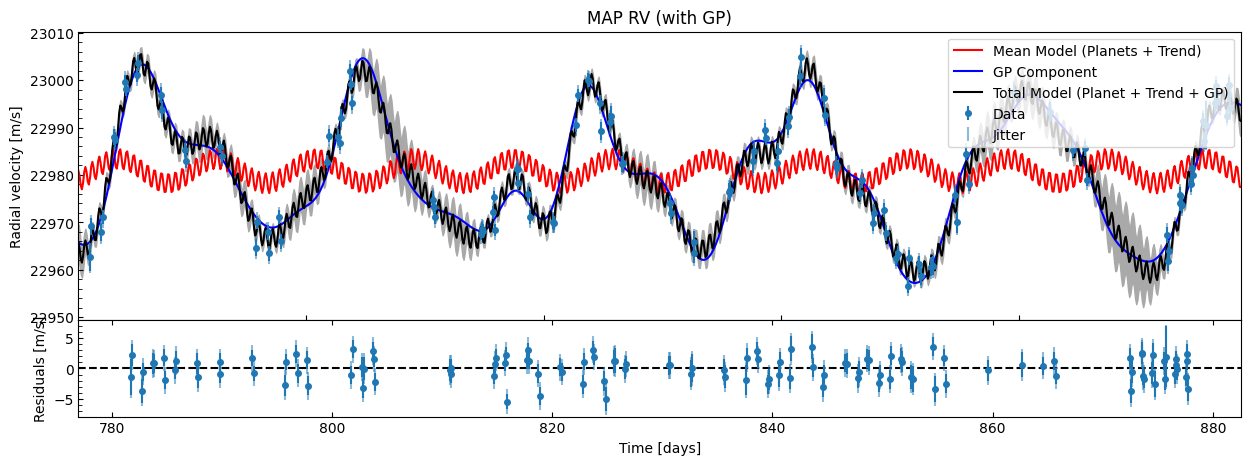

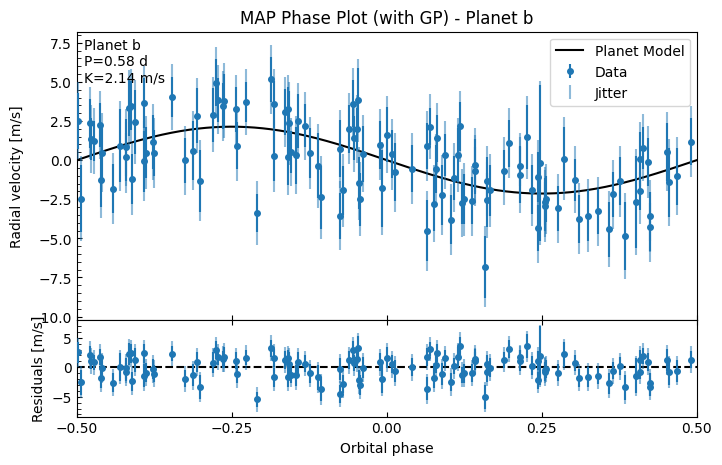

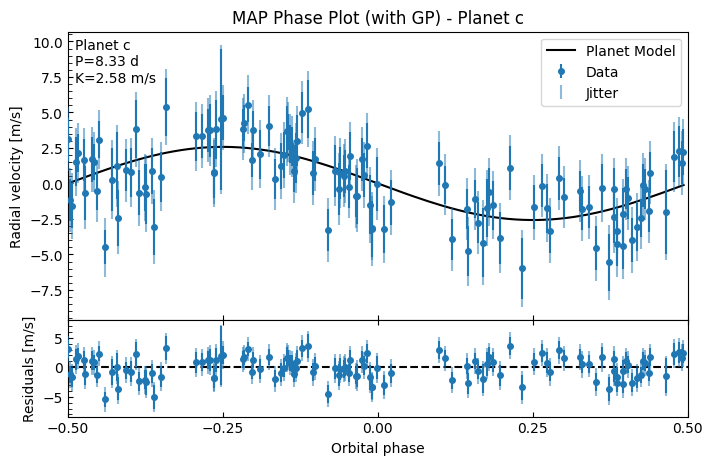

In [ ]:
gpfitter.plot_MAP_rv(map_result=gpmap_results)
gpfitter.plot_MAP_phase(planet_letter="b", map_result=gpmap_results)
gpfitter.plot_MAP_phase(planet_letter="c", map_result=gpmap_results)

This looks a lot better! The GP has fitted to the correlated noise well. The system RV residuals no longer look correlated (it now looks like white noise), and the planetary phase plots look much better.

Let's start MCMC. Again we will run this for the minimum number of walkers (two times the number of free parameters) initalised in a ball around the MAP results, and only run for a small number of steps so that this notebook runs quickly. You should definitely use more walkers and steps!

In [ ]:
nwalkers = 2 * gpfitter.ndim
mcmc_init = gpfitter.generate_initial_walker_positions_around_point(centre=gpmap_results.x, nwalkers=nwalkers, verbose=False)

In [ ]:
# Fit the free parameters to the data. Use the MAP solution as the initial value for the MCMC walkers.
gpfitter.run_mcmc(initial_positions=mcmc_init,
                  nwalkers=nwalkers, max_steps=20_000, progress=True,
                  multiprocessing=True,
                  check_convergence=True, convergence_check_interval=1000, convergence_check_start=15000
                  )  # This will take a few minutes!

INFO:root:Starting MCMC with convergence checks. (Maximum 20000 steps, checking convergence every 1000 steps after iteration 15000)...
INFO:2026-01-02 21:05:22,487:jax._src.xla_bridge:925: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:2026-01-02 21:05:22,489:jax._src.xla_bridge:925: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:2026-01-02 21:05:22,491:jax._src.xla_bridge:925: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file,

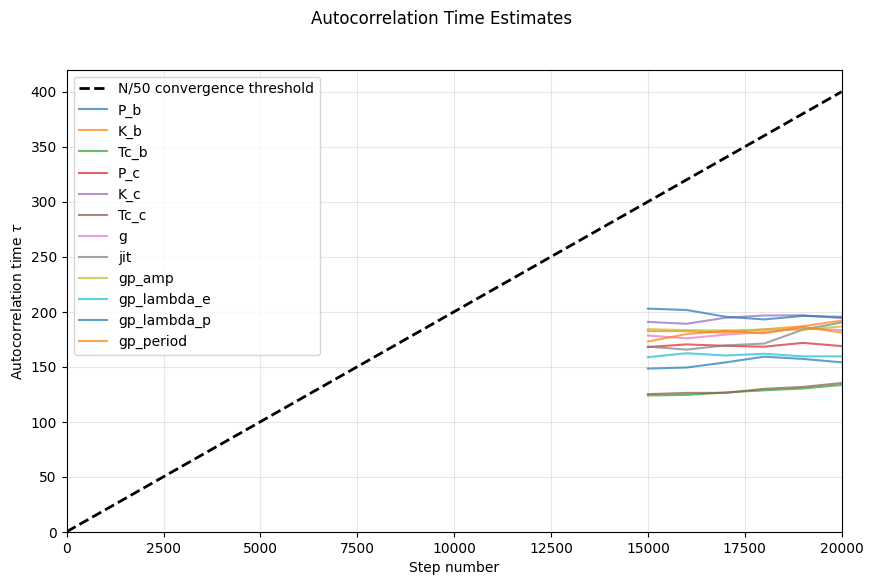

In [ ]:
gpfitter.plot_autocorr_estimates()

Looking at the autocorrelation estimate plot, we can consider these chains converged as the chains are all considerably longer then 50 times the estimated autocorrelation time, and the estimates look stable (even if they didn't quite meet the formal 1% stability criterion).

Again we'll take the last 10,000 iterations and thin by 10, to have 1,000 effective samples per walker.

In [ ]:
nburn = gpfitter.sampler.iteration - 10_000

# Get the samples as a numpy array
gpsamples = gpfitter.get_samples_np(discard_start=nburn, discard_end=0, thin=thin_rate, flat=False) # shape (nsteps, nwalkers, ndim)

# Get the samples as a labelled Pandas dataframe
gpsamples_df = gpfitter.get_samples_df(discard_start=nburn, discard_end=0, thin=10)  # shape (nsteps*nwalkers, ndim)
gpsamples_df

P_b       K_b        Tc_b       P_c       K_c        Tc_c  \
0      0.584261  1.958699  586.974910  8.324870  6.162902  536.375170   
1      0.584251  1.773442  586.973130  8.317940  3.633544  536.376142   
2      0.584288  2.091128  586.975043  8.345835  4.457828  536.378355   
3      0.584254  1.572038  586.972931  8.350223  2.636037  536.376936   
4      0.584245  2.453551  586.975672  8.333421  3.710036  536.376671   
...         ...       ...         ...       ...       ...         ...   
23995  0.584230  2.547182  586.974416  8.336955  3.846587  536.375747   
23996  0.584238  1.482840  586.973907  8.333638  5.140405  536.376841   
23997  0.584246  2.889003  586.975234  8.331679  5.375581  536.375188   
23998  0.584265  2.060854  586.973963  8.317872  1.307993  536.375800   
23999  0.584253  2.124808  586.974068  8.325871  4.602807  536.374610   

                  g       jit     gp_amp  gp_lambda_e  gp_lambda_p  gp_period  
0      22984.073960  1.683159  14.457549    18.257229     0.516386  18.108904  
1      22981.853179  1.156569  11.862153    16.746459     0.409478  18.243536  
2      22975.513526  1.653141   9.820077    17.370204     0.322584  18.855937  
3      22979.643785  2.101125  13.445681    17.690076     0.489398  18.400208  
4      22973.648094  1.577282  10.739664    18.057956     0.397576  18.756570  
...             ...       ...        ...          ...          ...        ...  
23995  22971.558769  2.251375  10.430879    15.159335     0.383244  18.678483  
23996  22979.738947  2.069920  20.801480    18.684499     0.502851  18.694478  
23997  22982.863945  1.383889  12.079421    15.331074     0.354735  17.548322  
23998  22981.450338  1.591446  12.350317    15.673183     0.483458  18.608835  
23999  22984.543481  1.491574  18.140232    17.051570     0.461927  18.007065  

[24000 rows x 12 columns]

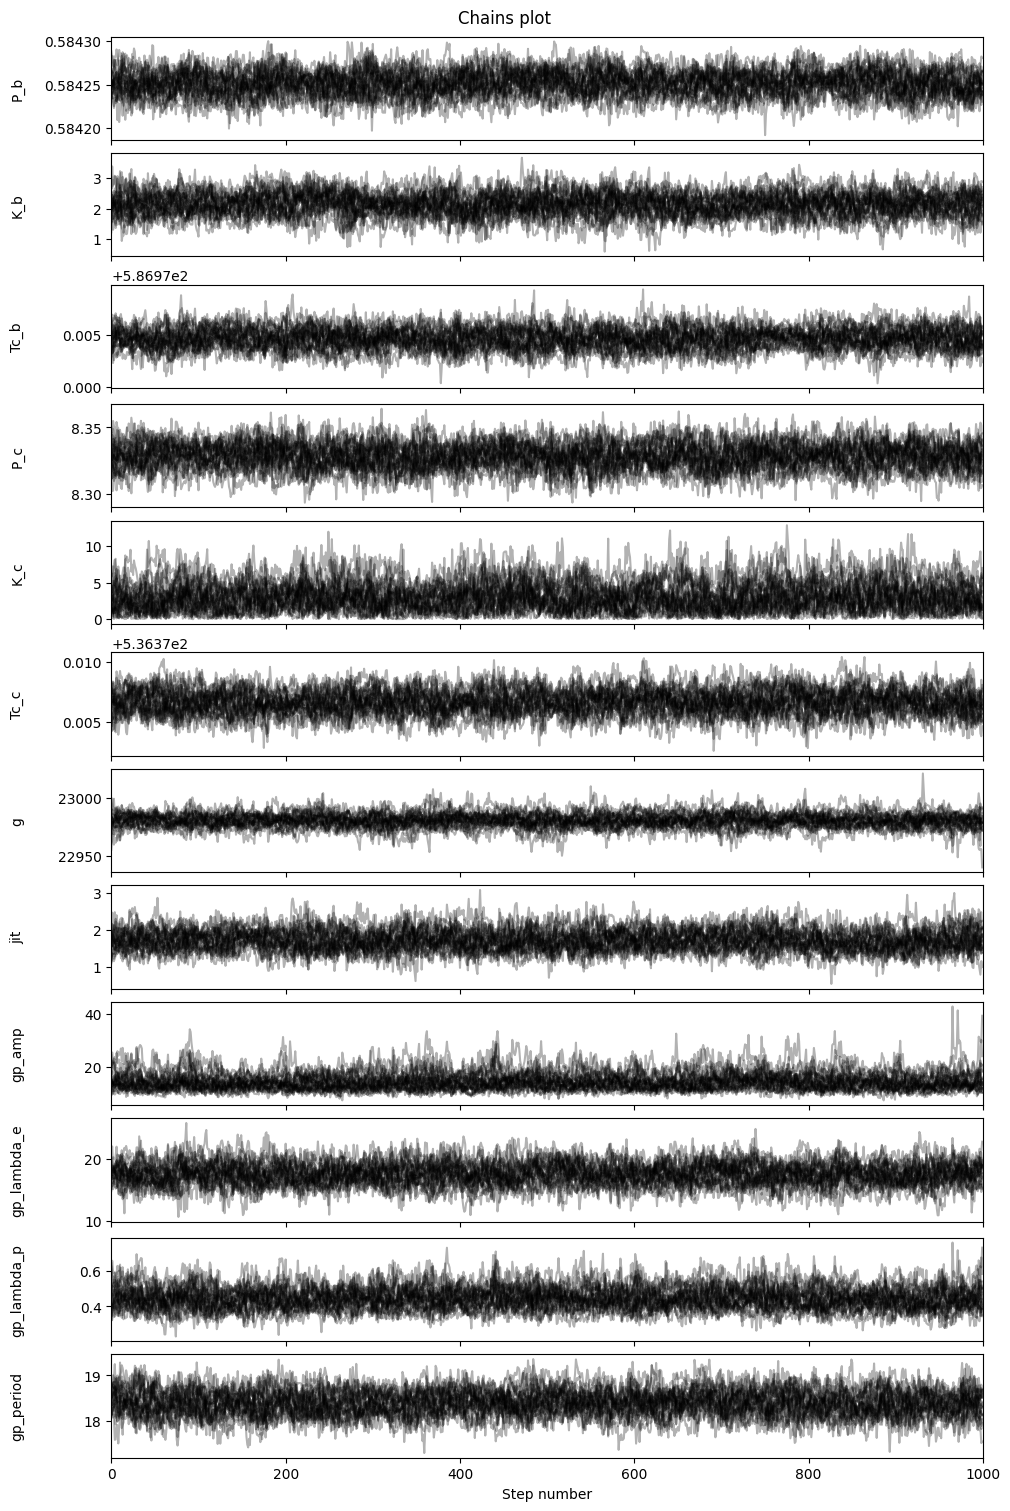

In [ ]:
gpfitter.plot_chains(discard_start=nburn, discard_end=0, thin=thin_rate, save=False)

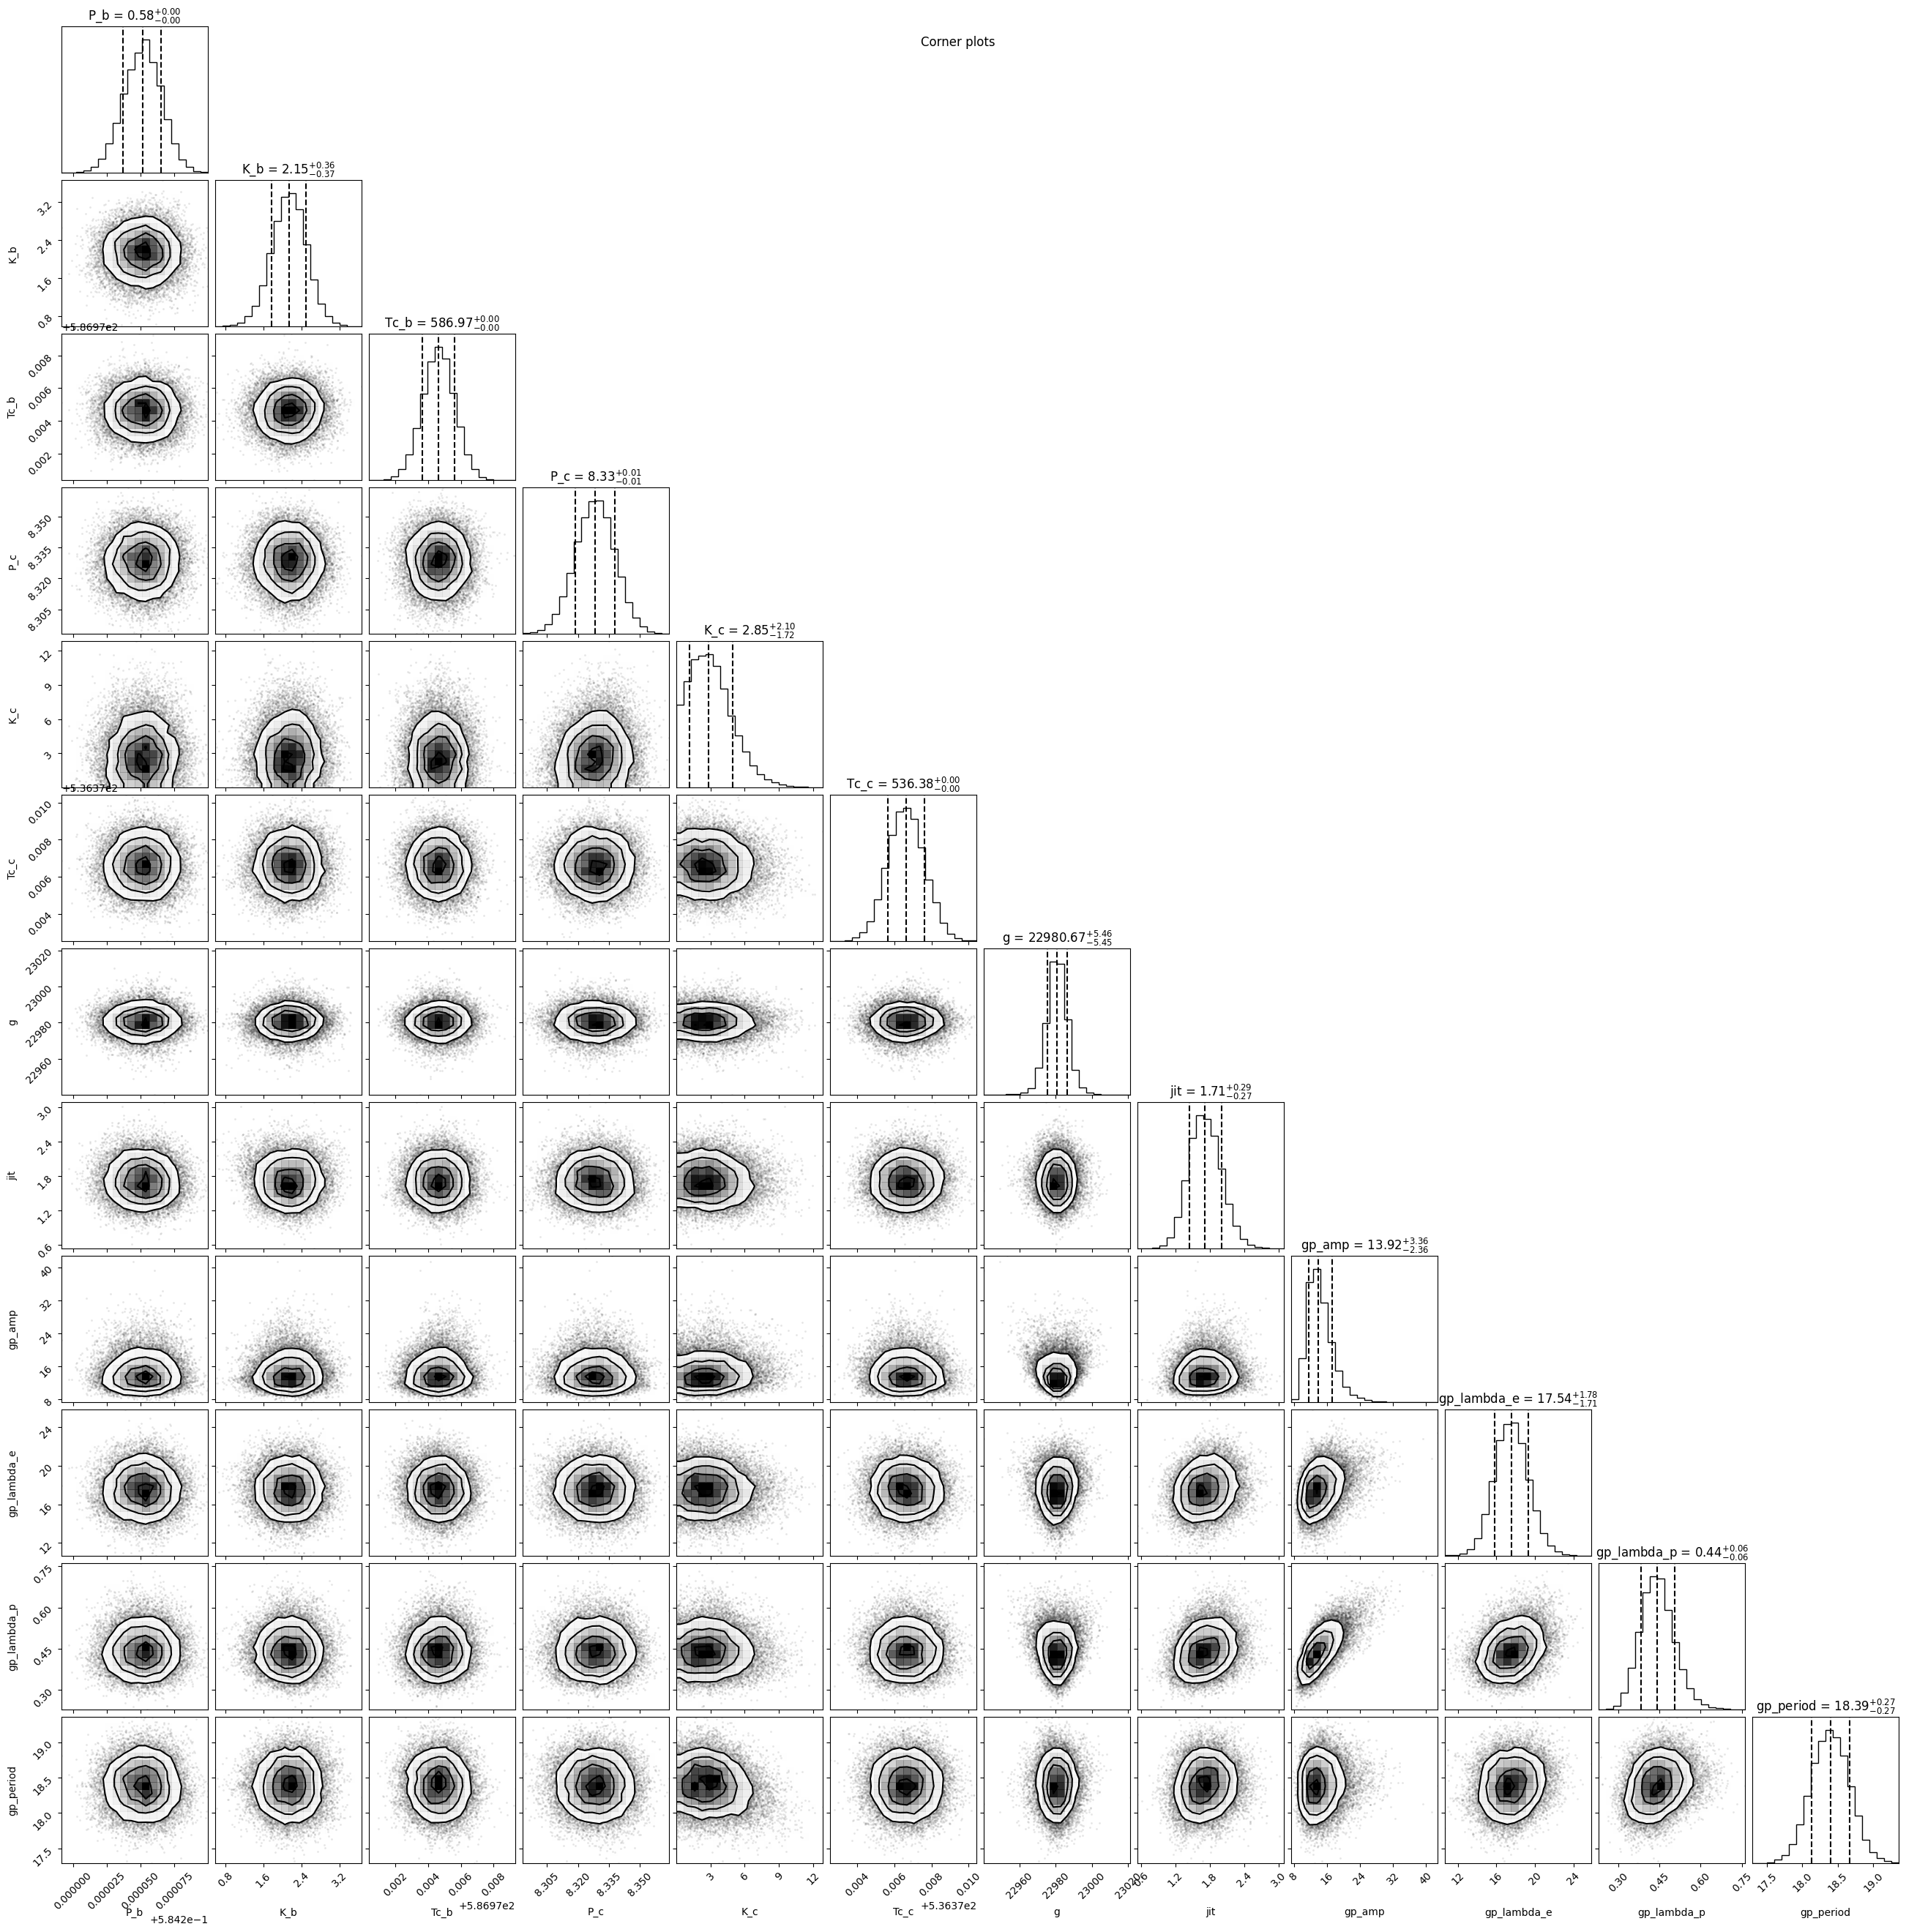

In [ ]:
gpfitter.plot_corner(discard_start=nburn, discard_end=0, thin=thin_rate, plot_datapoints=True, save=False,)

Chains and corners look good (unsurprising given the tight priors we imposed!) It's not uncommon for hyperparameters to often be multi-modal, if you encounter this then you may want to reconsider your choices of priors.

Let's look at the posterior RV and phase plots, with the GP's 1-$\sigma$ uncertainty plotted too. Again we 10x the thin rate here because these plots can take a while due to all the GP evaluations required from each sample.

Processing 2400 effective samples (after discard_start=10000, discard_end=0, thin=100)
Calculating planet b RV at 120 observed times...


Calculating planet b RV from samples: 100%|██████████| 2400/2400 [00:00<00:00, 40201.00it/s]


Calculating planet b RV at 1000 smooth times...


Calculating planet b RV from samples: 100%|██████████| 2400/2400 [00:00<00:00, 35741.32it/s]


Calculating planet c RV at 120 observed times...


Calculating planet c RV from samples: 100%|██████████| 2400/2400 [00:00<00:00, 56169.33it/s]


Calculating planet c RV at 1000 smooth times...


Calculating planet c RV from samples: 100%|██████████| 2400/2400 [00:00<00:00, 37221.91it/s]


Calculating trend RV at 120 observed times...


Calculating trend RV from samples: 100%|██████████| 2400/2400 [00:00<00:00, 99086.82it/s]


Calculating trend RV at 1000 smooth times...


Computing GP predictions: 100%|██████████| 2400/2400 [01:49<00:00, 21.89it/s]


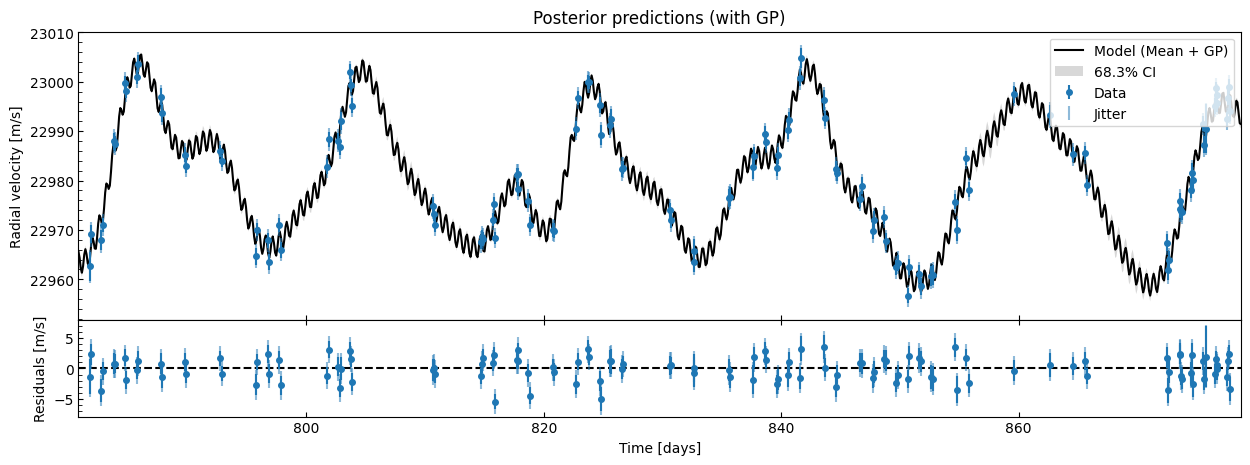

In [ ]:
# Use more aggressive thinning for RV/phase plots
plot_thin = thin_rate * 10

gpfitter.plot_posterior_rv(discard_start=nburn, discard_end=0, thin=plot_thin)

Processing 2400 effective samples (after discard_start=10000, discard_end=0, thin=100)
Calculating planet b RV at 120 observed times...


Calculating planet b RV from samples: 100%|██████████| 2400/2400 [00:00<00:00, 35016.73it/s]


Calculating planet b RV at 50 smooth times...


Calculating planet b RV from samples: 100%|██████████| 2400/2400 [00:00<00:00, 37079.32it/s]


Calculating planet c RV at 120 observed times...


Calculating planet c RV from samples: 100%|██████████| 2400/2400 [00:00<00:00, 37371.98it/s]


Calculating trend RV at 120 observed times...


100%|██████████| 2400/2400 [00:50<00:00, 47.22it/s]


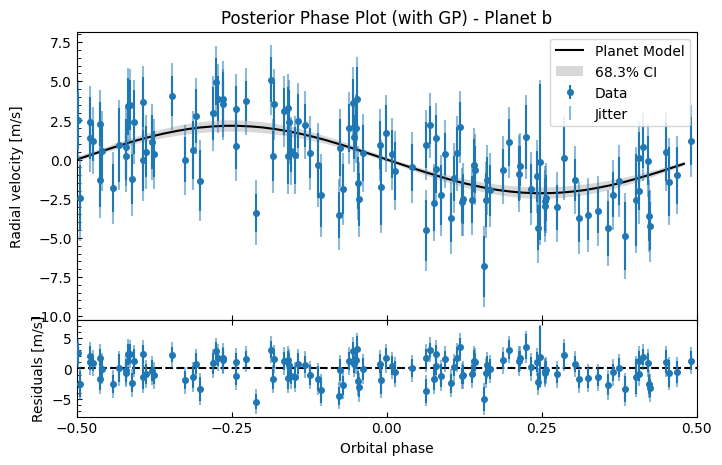

In [ ]:
gpfitter.plot_posterior_phase("b", discard_start=nburn, discard_end=0, thin=plot_thin)

Processing 2400 effective samples (after discard_start=10000, discard_end=0, thin=100)
Calculating planet c RV at 120 observed times...


Calculating planet c RV from samples: 100%|██████████| 2400/2400 [00:00<00:00, 30413.25it/s]


Calculating planet c RV at 50 smooth times...


Calculating planet c RV from samples: 100%|██████████| 2400/2400 [00:00<00:00, 36488.47it/s]


Calculating planet b RV at 120 observed times...


Calculating planet b RV from samples: 100%|██████████| 2400/2400 [00:00<00:00, 35411.66it/s]


Calculating trend RV at 120 observed times...


100%|██████████| 2400/2400 [00:46<00:00, 51.81it/s]


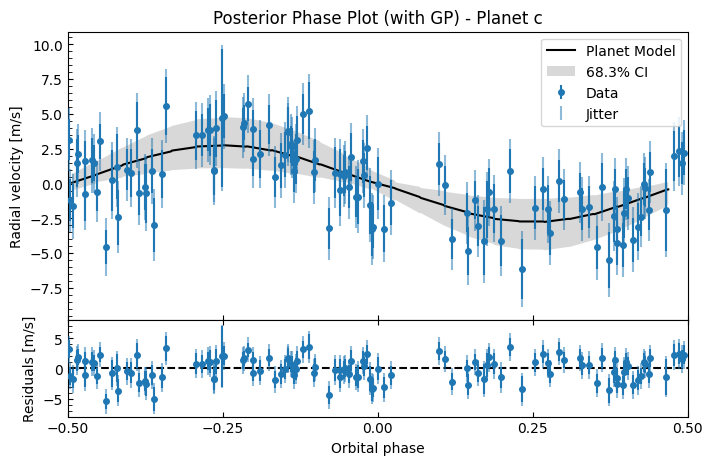

In [ ]:
gpfitter.plot_posterior_phase("c", discard_start=nburn, discard_end=0, thin=plot_thin)

In [ ]:
# For the GPFitter
print("Results for GPFitter (with Gaussian Process)")

# Get flattened samples (discard burn-in)
gpfitter_samples = gpfitter.get_samples_np(discard_start=nburn, discard_end=0, thin=1, flat=True)

# Calculate 50th percentile for each free parameter and hyperparameter
gpfitter_medians = np.percentile(gpfitter_samples, 50, axis=0)
print(f"\nMedian free parameter/hyperparameter values:")
all_names = gpfitter.free_params_names + gpfitter.free_hyperparams_names
for name, value in zip(all_names, gpfitter_medians):
    print(f"  {name}: {value}")

Results for GPFitter (with Gaussian Process)

Median free parameter/hyperparameter values:
  P_b: 0.584251782459333
  K_b: 2.1463250951301736
  Tc_b: 586.9746464275503
  P_c: 8.328273961699827
  K_c: 2.844105240768772
  Tc_c: 536.3766158433564
  g: 22980.67845507079
  jit: 1.71083729180548
  gp_amp: 13.917843092679108
  gp_lambda_e: 17.535135078438962
  gp_lambda_p: 0.4406399353621372
  gp_period: 18.3943612426387


In [ ]:
# Build complete params+hyperparams dict
gpfitter_complete_dict = gpfitter.build_params_dict(gpfitter_medians)
gpfitter_complete_dict

{'e_b': 0,
 'w_b': 1.5707963267948966,
 'e_c': 0,
 'w_c': 1.5707963267948966,
 'gd': 0,
 'gdd': 0,
 'P_b': 0.584251782459333,
 'K_b': 2.1463250951301736,
 'Tc_b': 586.9746464275503,
 'P_c': 8.328273961699827,
 'K_c': 2.844105240768772,
 'Tc_c': 536.3766158433564,
 'g': 22980.67845507079,
 'jit': 1.71083729180548,
 'gp_amp': 13.917843092679108,
 'gp_lambda_e': 17.535135078438962,
 'gp_lambda_p': 0.4406399353621372,
 'gp_period': 18.3943612426387}

In [ ]:
# Calculate metrics
gpfitter_chi2 = gpfitter.calculate_chi2(gpfitter_complete_dict)
gpfitter_loglike = gpfitter.calculate_log_likelihood(gpfitter_complete_dict)
gpfitter_aic = gpfitter.calculate_aic(gpfitter_complete_dict)
gpfitter_bic = gpfitter.calculate_bic(gpfitter_complete_dict)

print(f"\nMetrics at 50th percentile:")
print(f"  Chi^2:          {gpfitter_chi2:.2f}")
print(f"  Log-likelihood: {gpfitter_loglike:.2f}")
print(f"  AIC:            {gpfitter_aic:.2f}")
print(f"  BIC:            {gpfitter_bic:.2f}")


Metrics at 50th percentile:
  Chi^2:          112.47
  Log-likelihood: -338.21
  AIC:            700.42
  BIC:            733.87


---

# Model Comparison

Now let's compare the two models quantitatively using the metrics we've calculated. While visual inspection of the residuals clearly shows the GP model fits better, we can use statistical metrics to quantify this improvement.

In [ ]:
print(f"\n{'Metric':<20} {'No GP':>12} {'GP':>12}   {'':>20}")
print("-" * 70)
print(f"{'Free parameters':<20} {fitter.ndim:>12} {gpfitter.ndim:>12}")
print(f"{'Chi2':<20} {fitter_chi2:>12.2f} {gpfitter_chi2:>12.2f}   {'(lower is better)':>20}")
print(f"{'Log-likelihood':<20} {fitter_loglike:>12.2f} {gpfitter_loglike:>12.2f}   {'(higher is better)':>20}")
print(f"{'AIC':<20} {fitter_aic:>12.2f} {gpfitter_aic:>12.2f}   {'(lower is better)':>20}")
print(f"{'BIC':<20} {fitter_bic:>12.2f} {gpfitter_bic:>12.2f}   {'(lower is better)':>20}")


Metric                      No GP           GP                       
----------------------------------------------------------------------
Free parameters                 8           12
Chi2                       115.73       112.47      (lower is better)
Log-likelihood            -467.44      -338.21     (higher is better)
AIC                        950.87       700.42      (lower is better)
BIC                        973.17       733.87      (lower is better)


We can see that in all four metrics, the GP model is preferred, even with AIC and BIC despite the GP model having 4 additional free parameters.